#### By: Peyman Shahidi
#### Created: Oct 9, 2025
#### Last Edit: Oct 16, 2025

<br>

In [197]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [198]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [199]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [200]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Remove apostrophes for consistency
ONET = ONET.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Drop DWA columns
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# # Drop original Task ID and Task Title columns
# ONET = ONET.drop(columns=['Task ID', 'Task Title'])
# # Rename DWA ID and DWA Title to Task ID and Task Title
# ONET = ONET.rename(columns={'DWA ID': 'Task ID', 'DWA Title': 'Task Title'})

# Remove duplicate rows based on Occupation Title and new Task ID
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates(subset=['Occupation Title', 'Task ID']).reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,FT_Daily,FT_Hourly or more,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organizations financia...,Core,5,9.62,124.47,46.67,5.26,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,25.27,4.81,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,35.11,3.73,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.47,6.38,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,7.87,0.65,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [201]:
# Drop rows with missing wage values and report the impact
print("Removing occupations with missing wage data:")
print("=" * 50)

# Check missing wages before filtering
missing_wages_before = ONET['Hourly_Mean_Wage'].isnull().sum()
total_rows_before = len(ONET)
unique_occupations_before = len(ONET['O*NET-SOC Code'].unique())

print(f"Before filtering:")
print(f"Total rows: {total_rows_before:,}")
print(f"Unique occupations: {unique_occupations_before:,}")
print(f"Missing wage values: {missing_wages_before:,}")
print(f"Percentage missing: {(missing_wages_before / total_rows_before) * 100:.2f}%")

# Drop rows with missing wage values
ONET = ONET.dropna(subset=['Hourly_Mean_Wage'])

# Filter to keep only "Core" task types
rows_after_wage_filter = len(ONET)
print(f"\nAfter wage filtering: {rows_after_wage_filter:,} rows")

print(f"Task Type distribution before filtering:")
print(ONET['Task Type'].value_counts())

ONET = ONET[ONET['Task Type'] == 'Core']

# Report after all filtering
total_rows_after = len(ONET)
print(f"\nAfter filtering (wage + Core tasks only):")
print(f"Total rows: {total_rows_after:,}")
print(f"Rows removed: {total_rows_before - total_rows_after:,}")
print(f"Percentage of data retained: {(total_rows_after / total_rows_before) * 100:.2f}%")

# Check how many unique occupations were affected
unique_occupations_after = len(ONET['O*NET-SOC Code'].unique())
occupations_lost = unique_occupations_before - unique_occupations_after
print(f"\nUnique occupations after filtering: {unique_occupations_after:,}")
print(f"Occupations lost due to missing wages: {occupations_lost:,}")

ONET.head(5)

Removing occupations with missing wage data:
Before filtering:
Total rows: 17,953
Unique occupations: 873
Missing wage values: 434
Percentage missing: 2.42%

After wage filtering: 17,519 rows
Task Type distribution before filtering:
Task Type
Core            12901
Supplemental     4618
Name: count, dtype: int64

After filtering (wage + Core tasks only):
Total rows: 12,901
Rows removed: 5,052
Percentage of data retained: 71.86%

Unique occupations after filtering: 849
Occupations lost due to missing wages: 24


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,FT_Daily,FT_Hourly or more,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organizations financia...,Core,5,9.62,124.47,46.67,5.26,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,25.27,4.81,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,35.11,3.73,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.47,6.38,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,7.87,0.65,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [202]:
# Create dataset with selected columns and unique task count
selected_columns = ['O*NET-SOC Code', 'Occupation Title', 'Hourly_Mean_Wage', 'Job Zone', 'Task ID']
onet_filtered = ONET[selected_columns].copy()

# Add unique task count per occupation
task_counts = onet_filtered.groupby('O*NET-SOC Code')['Task ID'].nunique().reset_index()
task_counts.columns = ['O*NET-SOC Code', 'Unique_Task_Count']
occupation_df = onet_filtered.merge(task_counts, on='O*NET-SOC Code', how='left')
occupation_df = occupation_df.drop(columns=['Task ID'])

# Create occupation dataframe
occupation_summary = occupation_df.drop_duplicates(subset=['O*NET-SOC Code', 'Occupation Title', 'Hourly_Mean_Wage', 'Job Zone', 'Unique_Task_Count']).reset_index()
occupation_summary.head()

,index,O*NET-SOC Code,Occupation Title,Hourly_Mean_Wage,Job Zone,Unique_Task_Count
0,0,11-1011.00,Chief Executives,124.47,5,19
1,19,11-1011.03,Chief Sustainability Officers,124.47,5,18
2,37,11-1021.00,General and Operations Managers,62.18,4,9
3,46,11-2011.00,Advertising and Promotions Managers,73.38,4,13
4,59,11-2021.00,Marketing Managers,80.00,4,12


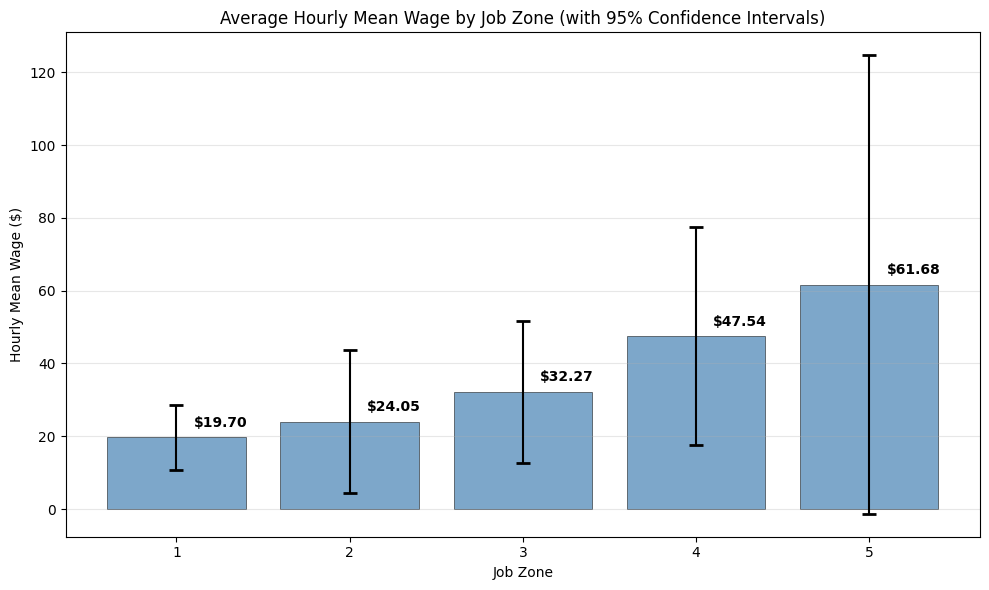

Summary by Job Zone:
          count  mean  median   std
Job Zone                           
1            31 19.70   18.88  4.53
2           267 24.05   22.43 10.07
3           204 32.27   30.61  9.96
4           198 47.54   45.46 15.28
5           149 61.68   49.17 32.13


In [203]:
# Create bar plot of Hourly Mean Wage vs Job Zone with error bars
plt.figure(figsize=(10, 6))

# Calculate mean and standard deviation for each job zone
job_zones = sorted(occupation_summary['Job Zone'].unique())
means = []
stds = []

for zone in job_zones:
    zone_data = occupation_summary[occupation_summary['Job Zone'] == zone]
    means.append(zone_data['Hourly_Mean_Wage'].mean())
    stds.append(zone_data['Hourly_Mean_Wage'].std())

# Create bar plot with error bars (1.96 * std for 95% confidence interval)
error_bars = [1.96 * std for std in stds]

plt.bar(job_zones, means, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
plt.errorbar(job_zones, means, yerr=error_bars, fmt='none', color='black', capsize=5, capthick=2)

plt.xlabel('Job Zone')
plt.ylabel('Hourly Mean Wage ($)')
plt.title('Average Hourly Mean Wage by Job Zone (with 95% Confidence Intervals)')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars (just above the bar, not above error bars)
for i, (zone, mean, std) in enumerate(zip(job_zones, means, stds)):
    plt.text(zone + 0.1, mean + 2, f'${mean:.2f}', 
             ha='left', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary by Job Zone:")
summary_stats = occupation_summary.groupby('Job Zone')['Hourly_Mean_Wage'].agg(['count', 'mean', 'median', 'std']).round(2)
print(summary_stats)

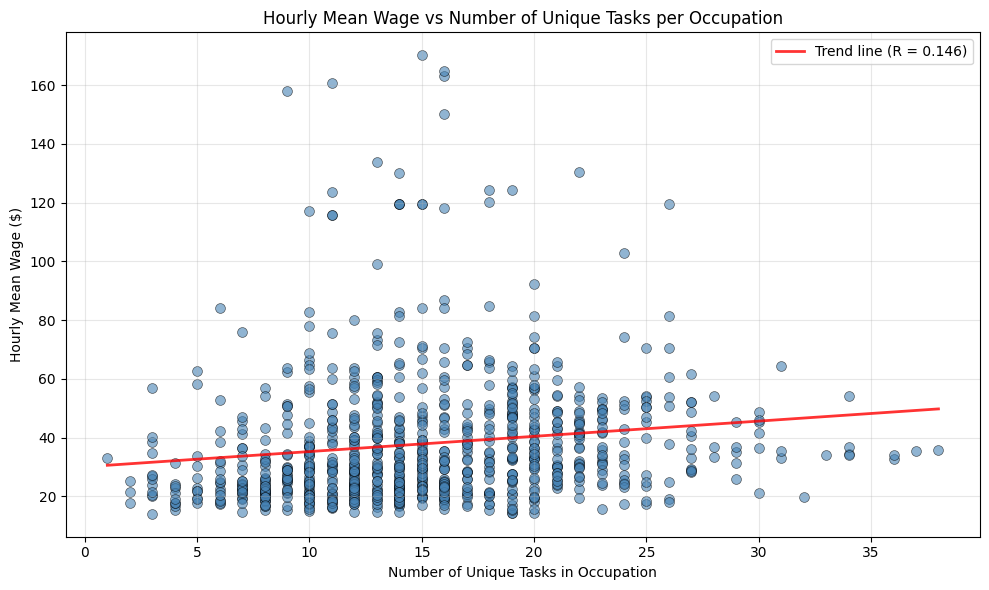

Correlation coefficient: 0.146
R-squared: 0.021
Slope: $0.52 per additional task

Unique Task Count Summary:
count   849.00
mean     15.20
std       6.25
min       1.00
25%      11.00
50%      14.00
75%      19.00
max      38.00
Name: Unique_Task_Count, dtype: float64

Number of occupations: 849


In [204]:
# Create scatter plot of Hourly Mean Wage vs Number of Unique Tasks
plt.figure(figsize=(10, 6))

# Remove any rows with missing values for correlation calculation
clean_data = occupation_summary[['Unique_Task_Count', 'Hourly_Mean_Wage']].dropna()

plt.scatter(clean_data['Unique_Task_Count'], clean_data['Hourly_Mean_Wage'], 
           alpha=0.6, s=50, color='steelblue', edgecolor='black', linewidth=0.5)

plt.xlabel('Number of Unique Tasks in Occupation')
plt.ylabel('Hourly Mean Wage ($)')
plt.title('Hourly Mean Wage vs Number of Unique Tasks per Occupation')
plt.grid(True, alpha=0.3)

# Add a trend line
import numpy as np
if len(clean_data) > 1:
    correlation = clean_data['Unique_Task_Count'].corr(clean_data['Hourly_Mean_Wage'])
    
    # Fit linear regression
    z = np.polyfit(clean_data['Unique_Task_Count'], clean_data['Hourly_Mean_Wage'], 1)
    p = np.poly1d(z)
    
    x_line = np.linspace(clean_data['Unique_Task_Count'].min(), clean_data['Unique_Task_Count'].max(), 100)
    plt.plot(x_line, p(x_line), 'r-', alpha=0.8, linewidth=2, 
             label=f'Trend line (R = {correlation:.3f})')
    
    plt.legend()

plt.tight_layout()
plt.show()

# Print correlation statistics
print(f"Correlation coefficient: {correlation:.3f}")
print(f"R-squared: {correlation**2:.3f}")
print(f"Slope: ${z[0]:.2f} per additional task")

# Show summary statistics
print(f"\nUnique Task Count Summary:")
print(clean_data['Unique_Task_Count'].describe())
print(f"\nNumber of occupations: {len(clean_data)}")

In [205]:
# Sort occupations by mean wage in descending order
occupation_sorted = occupation_summary.sort_values('Hourly_Mean_Wage', ascending=False).reset_index(drop=True)

print("Top 20 Highest-Paid Occupations:")
print("=" * 80)
top_20 = occupation_sorted.head(20)[['Occupation Title', 'Hourly_Mean_Wage', 'Job Zone', 'Unique_Task_Count']]
for i, row in top_20.iterrows():
    print(f"{i+1:2d}. {row['Occupation Title']:<50} ${row['Hourly_Mean_Wage']:>6.2f} | Zone {row['Job Zone']} | {row['Unique_Task_Count']:2d} tasks")

print("\n" + "=" * 80)
print("Bottom 20 Lowest-Paid Occupations:")
print("=" * 80)
bottom_20 = occupation_sorted.tail(20)[['Occupation Title', 'Hourly_Mean_Wage', 'Job Zone', 'Unique_Task_Count']]
for i, row in bottom_20.iterrows():
    print(f"{len(occupation_sorted)-19+i-len(occupation_sorted)+20:2d}. {row['Occupation Title']:<50} ${row['Hourly_Mean_Wage']:>6.2f} | Zone {row['Job Zone']} | {row['Unique_Task_Count']:2d} tasks")

print(f"\nTotal occupations: {len(occupation_sorted)}")
print(f"Wage range: ${occupation_sorted['Hourly_Mean_Wage'].min():.2f} - ${occupation_sorted['Hourly_Mean_Wage'].max():.2f}")
print(f"Median wage: ${occupation_sorted['Hourly_Mean_Wage'].median():.2f}")

Top 20 Highest-Paid Occupations:
 1. Radiologists                                       $170.17 | Zone 5 | 15 tasks
 2. Dermatologists                                     $164.84 | Zone 5 | 16 tasks
 3. Anesthesiologists                                  $163.21 | Zone 5 | 16 tasks
 4. Oral and Maxillofacial Surgeons                    $160.73 | Zone 5 | 11 tasks
 5. Athletes and Sports Competitors                    $158.09 | Zone 2 |  9 tasks
 6. Ophthalmologists, Except Pediatric                 $150.06 | Zone 5 | 16 tasks
 7. Obstetricians and Gynecologists                    $133.97 | Zone 5 | 13 tasks
 8. Neurologists                                       $130.51 | Zone 5 | 22 tasks
 9. Physicians, Pathologists                           $130.08 | Zone 5 | 14 tasks
10. Chief Sustainability Officers                      $124.47 | Zone 5 | 18 tasks
11. Chief Executives                                   $124.47 | Zone 5 | 19 tasks
12. Psychiatrists                                     

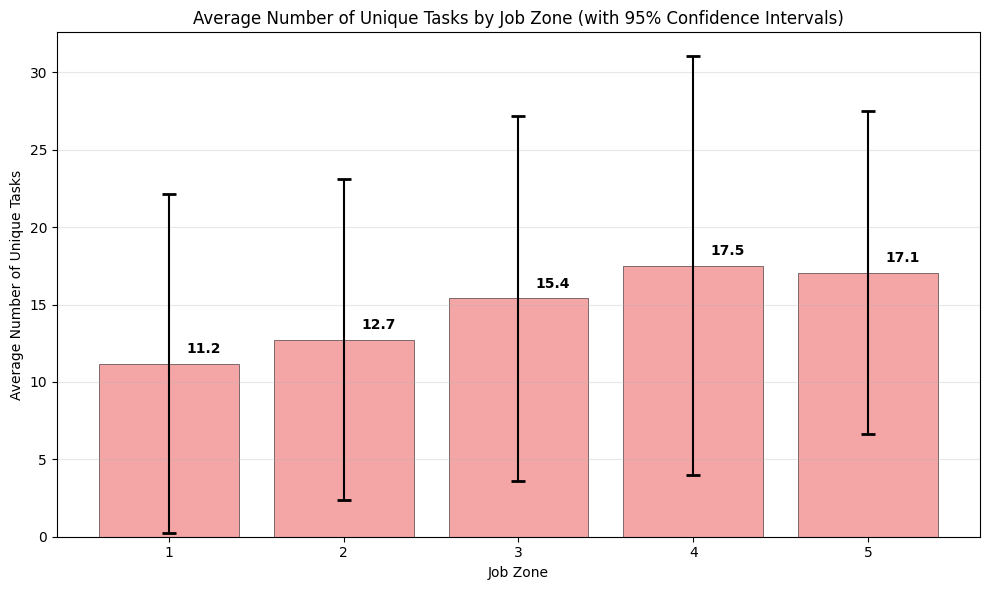

Task Count Summary by Job Zone:
          count  mean  median  std
Job Zone                          
1            31 11.19   10.00 5.60
2           267 12.74   13.00 5.31
3           204 15.40   15.00 6.03
4           198 17.52   16.00 6.90
5           149 17.06   17.00 5.32

Correlation between Job Zone and Task Count: 0.311
R-squared: 0.097


In [206]:
# Create bar plot of Number of Unique Tasks vs Job Zone
plt.figure(figsize=(10, 6))

# Calculate mean and standard deviation of task counts for each job zone
job_zones = sorted(occupation_summary['Job Zone'].unique())
task_means = []
task_stds = []

for zone in job_zones:
    zone_data = occupation_summary[occupation_summary['Job Zone'] == zone]
    task_means.append(zone_data['Unique_Task_Count'].mean())
    task_stds.append(zone_data['Unique_Task_Count'].std())

# Create bar plot with error bars (1.96 * std for 95% confidence interval)
task_error_bars = [1.96 * std for std in task_stds]

plt.bar(job_zones, task_means, alpha=0.7, color='lightcoral', edgecolor='black', linewidth=0.5)
plt.errorbar(job_zones, task_means, yerr=task_error_bars, fmt='none', color='black', capsize=5, capthick=2)

plt.xlabel('Job Zone')
plt.ylabel('Average Number of Unique Tasks')
plt.title('Average Number of Unique Tasks by Job Zone (with 95% Confidence Intervals)')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars
for i, (zone, mean, std) in enumerate(zip(job_zones, task_means, task_stds)):
    plt.text(zone + 0.1, mean + 0.5, f'{mean:.1f}', 
             ha='left', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Task Count Summary by Job Zone:")
task_summary = occupation_summary.groupby('Job Zone')['Unique_Task_Count'].agg(['count', 'mean', 'median', 'std']).round(2)
print(task_summary)

# Calculate correlation between job zone and task count
correlation_zone_tasks = occupation_summary['Job Zone'].corr(occupation_summary['Unique_Task_Count'])
print(f"\nCorrelation between Job Zone and Task Count: {correlation_zone_tasks:.3f}")
print(f"R-squared: {correlation_zone_tasks**2:.3f}")